In [2]:
import sys
import os
import time
import random
import numpy as np
import copy
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import config
from celeba_dataset import CelebaDataset

# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

In [3]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

In [26]:
# Data augmentation and normalization for training
# Just normalization for validation and testing

def load_dataloader(print_info=True, albu_transforms = True):
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }
    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        data_transforms = {
            'train': transforms.Compose([
                transforms.CenterCrop((198, 158)), #new
                transforms.RandomRotation(degrees=10), #new
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                normalize,
                transforms.RandomErasing(p=0.2)
            ]),
            'val': transforms.Compose([
                transforms.CenterCrop((198, 158)), #new
                transforms.ToTensor(),
                normalize
            ]),
            'test': transforms.Compose([
                transforms.CenterCrop((198, 158)), #new
                transforms.ToTensor(),
                normalize
            ])
        }
    else:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                                  std=(0.229, 0.224, 0.225))
        data_transforms = {
            'train': A.Compose([
                #A.RandomResizedCrop(148, 148), # cuts out too much attributes, use centercrop instead
                A.CenterCrop(height=218, width=168),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                                 rotate_limit=15, p=0.5), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
                A.HorizontalFlip(p=0.5),
                #A.HueSaturationValue(hue_shift_limit=14, sat_shift_limit=14, val_shift_limit=14, p=0.5),
                #A.FancyPCA(alpha=0.1, p=0.5), #http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
                #A.RandomBrightnessContrast(p=0.5),
                #A.GaussNoise(var_limit=10.0, p=0.5), 
                #A.GaussianBlur(p=0.1), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
                #A.CoarseDropout(max_holes=1, max_height=74, max_width=74, 
                #               min_height=49, min_width=49, fill_value=0, p=0.2), #https://arxiv.org/pdf/1708.04896.pdf
                normalize_A,
                ToTensorV2(),
                
            ]),
            'val': A.Compose([
                #Rescale an image so that minimum side is equal to max_size 178 (shortest edge of celeba)
                #A.SmallestMaxSize(max_size=178), 
                A.CenterCrop(height=218, width=168),
                normalize_A,
                ToTensorV2(),
            ]),
            'test': A.Compose([
                #A.SmallestMaxSize(max_size=178),
                A.CenterCrop(height=218, width=168),
                normalize_A,
                ToTensorV2(),
            ])
        }


    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x], albu=albu_transforms) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
        
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return image_datasets, dataloaders, attribute_names

In [27]:
albu_transforms = True
image_datasets, dataloaders, attr_names = load_dataloader(albu_transforms = albu_transforms)

Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40


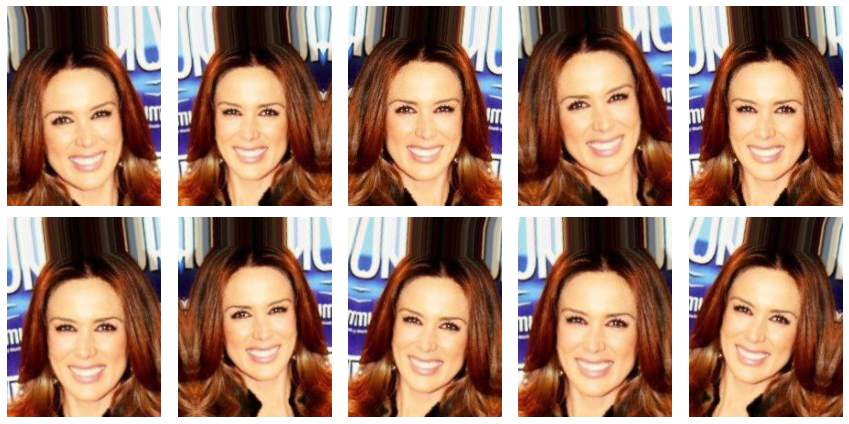

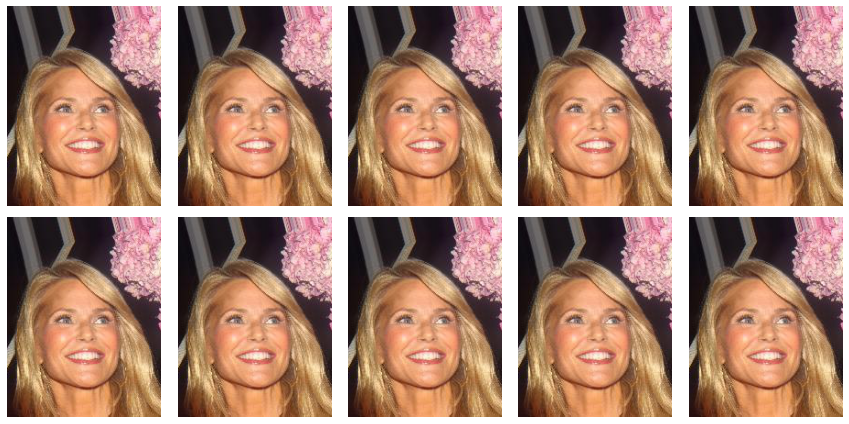

In [28]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()   

if albu_transforms:
    visualize_augmentations(image_datasets['train'], idx=44)
    visualize_augmentations(image_datasets['val'], idx=44)

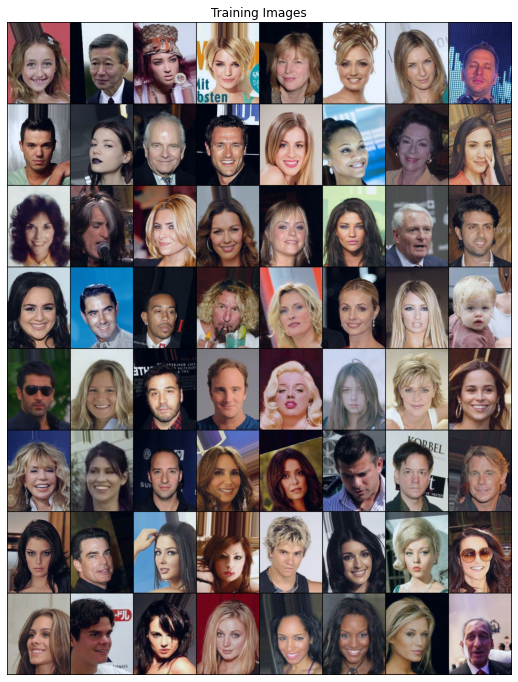

In [29]:
# # decide which device we want to run on
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
real_batch = next(iter(dataloaders['train']))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
# Before V9.1
#                 A.SmallestMaxSize(max_size=160),
#                 A.HorizontalFlip(p=0.5),
#                 A.MotionBlur(p=0.1),
#                 A.GaussNoise(p=0.5),
#                 A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
#                                    rotate_limit=15, p=0.5),
#                 A.RandomBrightnessContrast(p=0.5),
#                 #A.CoarseDropout(),
#                 normalize_A,
#                 ToTensorV2(),

In [8]:
# V9.1
data_transforms = {
    'train': A.Compose([
        A.SmallestMaxSize(max_size=160),
        #A.RandomCrop(width=148, height=148),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                          rotate_limit=15, p=0.5),
        A.FancyPCA(p=0.5), #http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
        A.GaussNoise(var_limit=(10.0, 80.0), p=0.5),
        A.GaussianBlur(p=0.2),
        A.RandomBrightnessContrast(p=0.5),
        #A.CoarseDropout(),
        normalize_A,
        ToTensorV2(),
    ]),
    'val': A.Compose([
        A.SmallestMaxSize(max_size=160),
        #A.CenterCrop(height=148, width=148),
        normalize_A,
        ToTensorV2(),
    ]),
    'test': A.Compose([
        A.SmallestMaxSize(max_size=160),
        #A.CenterCrop(height=148, width=148),
        normalize_A,
        ToTensorV2(),
    ])
}

NameError: name 'normalize_A' is not defined

In [ ]:
# V1.1
data_transforms = {
    'train': A.Compose([
        #A.RandomResizedCrop(148, 148), # cuts out too much attributes, use centercrop instead
        A.CenterCrop(height=148, width=148),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                          rotate_limit=15, p=0.5), # not in bags of tricks
        A.HorizontalFlip(p=0.5),
        A.HueSaturationValue(hue_shift_limit=14, sat_shift_limit=14, val_shift_limit=14, p=0.5),
        A.FancyPCA(alpha=0.1, p=0.5), #http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
        A.GaussNoise(var_limit=10.0, p=0.5), 
        A.CoarseDropout(max_holes=1, max_height=74, max_width=74, 
                        min_height=49, min_width=49, fill_value=0, p=0.2), #https://arxiv.org/pdf/1708.04896.pdf
        normalize_A,
        ToTensorV2(),

    ]),
    'val': A.Compose([
        #Rescale an image so that minimum side is equal to max_size 178 (shortest edge of celeba)
        A.SmallestMaxSize(max_size=178), 
        A.CenterCrop(height=148, width=148),
        normalize_A,
        ToTensorV2(),
    ]),
    'test': A.Compose([
        A.SmallestMaxSize(max_size=178),
        A.CenterCrop(height=148, width=148),
        normalize_A,
        ToTensorV2(),
    ])
}

In [ ]:
# V1.2
data_transforms = {
    'train': A.Compose([
        #A.RandomResizedCrop(148, 148), # cuts out too much attributes, use centercrop instead
        A.CenterCrop(height=168, width=168),
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, 
        #                  rotate_limit=20, p=0.5), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
        A.HorizontalFlip(p=0.5),
        A.HueSaturationValue(hue_shift_limit=14, sat_shift_limit=14, val_shift_limit=14, p=0.5),
        A.FancyPCA(alpha=0.1, p=0.5), #http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
        #A.GaussianBlur(p=0.1), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
        A.GaussNoise(var_limit=10.0, p=0.5), 
        #A.CoarseDropout(max_holes=1, max_height=74, max_width=74, 
        #                min_height=49, min_width=49, fill_value=0, p=0.2), #https://arxiv.org/pdf/1708.04896.pdf
        normalize_A,
        ToTensorV2(),

    ]),
    'val': A.Compose([
        #Rescale an image so that minimum side is equal to max_size 178 (shortest edge of celeba)
        A.SmallestMaxSize(max_size=178), 
        A.CenterCrop(height=168, width=168),
        normalize_A,
        ToTensorV2(),
    ]),
    'test': A.Compose([
        A.SmallestMaxSize(max_size=178),
        A.CenterCrop(height=168, width=168),
        normalize_A,
        ToTensorV2(),
    ])
}